Construct a model for scoring
-----------------

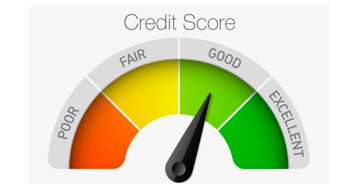

**The main objective of the project is to create a credit scoring algorithm that predicts the chance of a given loan applicant defaulting on loan repayment.**

In [1]:
# import certain libraries
import pandas as pd
import numpy as np
import seaborn as sns
from math import sqrt
import matplotlib.pyplot as plt
%matplotlib inline
from xgboost import XGBClassifier

import warnings
warnings.filterwarnings('ignore')

import shap
from shap import TreeExplainer, summary_plot
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler 
from sklearn.preprocessing import OrdinalEncoder, LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import GradientBoostingClassifier, AdaBoostClassifier, RandomForestClassifier
from sklearn import metrics
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix, classification_report, precision_score, recall_score, f1_score, accuracy_score
from sklearn.model_selection import cross_val_score
from sklearn import tree
from sklearn.metrics import roc_auc_score,fbeta_score, make_scorer

### We import only the csv file train from home credit default risk

In [2]:
df=pd.read_csv('application_train.csv', sep =',')

In [3]:
df.head()

,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,...,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
0,100002,1,Cash loans,M,N,Y,0,202500.0,406597.5,24700.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,1.0
1,100003,0,Cash loans,F,N,N,0,270000.0,1293502.5,35698.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
2,100004,0,Revolving loans,M,Y,Y,0,67500.0,135000.0,6750.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
3,100006,0,Cash loans,F,N,Y,0,135000.0,312682.5,29686.5,...,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
4,100007,0,Cash loans,M,N,Y,0,121500.0,513000.0,21865.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0


In [4]:
df.columns

Index(['SK_ID_CURR', 'TARGET', 'NAME_CONTRACT_TYPE', 'CODE_GENDER',
       'FLAG_OWN_CAR', 'FLAG_OWN_REALTY', 'CNT_CHILDREN', 'AMT_INCOME_TOTAL',
       'AMT_CREDIT', 'AMT_ANNUITY',
       ...
       'FLAG_DOCUMENT_18', 'FLAG_DOCUMENT_19', 'FLAG_DOCUMENT_20',
       'FLAG_DOCUMENT_21', 'AMT_REQ_CREDIT_BUREAU_HOUR',
       'AMT_REQ_CREDIT_BUREAU_DAY', 'AMT_REQ_CREDIT_BUREAU_WEEK',
       'AMT_REQ_CREDIT_BUREAU_MON', 'AMT_REQ_CREDIT_BUREAU_QRT',
       'AMT_REQ_CREDIT_BUREAU_YEAR'],
      dtype='object', length=122)

In [5]:
print(f' There are {df.shape[0]} rows in the dataset')
print(f' There are {df.shape[1]} columns in the dataset')

 There are 307511 rows in the dataset
 There are 122 columns in the dataset


In [6]:
#Numerical columns in the data
list(df.select_dtypes(['number']).columns)

['SK_ID_CURR',
 'TARGET',
 'CNT_CHILDREN',
 'AMT_INCOME_TOTAL',
 'AMT_CREDIT',
 'AMT_ANNUITY',
 'AMT_GOODS_PRICE',
 'REGION_POPULATION_RELATIVE',
 'DAYS_BIRTH',
 'DAYS_EMPLOYED',
 'DAYS_REGISTRATION',
 'DAYS_ID_PUBLISH',
 'OWN_CAR_AGE',
 'FLAG_MOBIL',
 'FLAG_EMP_PHONE',
 'FLAG_WORK_PHONE',
 'FLAG_CONT_MOBILE',
 'FLAG_PHONE',
 'FLAG_EMAIL',
 'CNT_FAM_MEMBERS',
 'REGION_RATING_CLIENT',
 'REGION_RATING_CLIENT_W_CITY',
 'HOUR_APPR_PROCESS_START',
 'REG_REGION_NOT_LIVE_REGION',
 'REG_REGION_NOT_WORK_REGION',
 'LIVE_REGION_NOT_WORK_REGION',
 'REG_CITY_NOT_LIVE_CITY',
 'REG_CITY_NOT_WORK_CITY',
 'LIVE_CITY_NOT_WORK_CITY',
 'EXT_SOURCE_1',
 'EXT_SOURCE_2',
 'EXT_SOURCE_3',
 'APARTMENTS_AVG',
 'BASEMENTAREA_AVG',
 'YEARS_BEGINEXPLUATATION_AVG',
 'YEARS_BUILD_AVG',
 'COMMONAREA_AVG',
 'ELEVATORS_AVG',
 'ENTRANCES_AVG',
 'FLOORSMAX_AVG',
 'FLOORSMIN_AVG',
 'LANDAREA_AVG',
 'LIVINGAPARTMENTS_AVG',
 'LIVINGAREA_AVG',
 'NONLIVINGAPARTMENTS_AVG',
 'NONLIVINGAREA_AVG',
 'APARTMENTS_MODE',
 'BASEMENTAR

In [7]:
#Categorical columns in the data
list(df.select_dtypes(['object']).columns)

['NAME_CONTRACT_TYPE',
 'CODE_GENDER',
 'FLAG_OWN_CAR',
 'FLAG_OWN_REALTY',
 'NAME_TYPE_SUITE',
 'NAME_INCOME_TYPE',
 'NAME_EDUCATION_TYPE',
 'NAME_FAMILY_STATUS',
 'NAME_HOUSING_TYPE',
 'OCCUPATION_TYPE',
 'WEEKDAY_APPR_PROCESS_START',
 'ORGANIZATION_TYPE',
 'FONDKAPREMONT_MODE',
 'HOUSETYPE_MODE',
 'WALLSMATERIAL_MODE',
 'EMERGENCYSTATE_MODE']

In [8]:
df.describe()

,SK_ID_CURR,TARGET,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,...,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
count,307511.000000,307511.000000,307511.000000,3.075110e+05,3.075110e+05,307499.000000,3.072330e+05,307511.000000,307511.000000,307511.000000,...,307511.000000,307511.000000,307511.000000,307511.000000,265992.000000,265992.000000,265992.000000,265992.000000,265992.000000,265992.000000
mean,278180.518577,0.080729,0.417052,1.687979e+05,5.990260e+05,27108.573909,5.383962e+05,0.020868,-16036.995067,63815.045904,...,0.008130,0.000595,0.000507,0.000335,0.006402,0.007000,0.034362,0.267395,0.265474,1.899974
std,102790.175348,0.272419,0.722121,2.371231e+05,4.024908e+05,14493.737315,3.694465e+05,0.013831,4363.988632,141275.766519,...,0.089798,0.024387,0.022518,0.018299,0.083849,0.110757,0.204685,0.916002,0.794056,1.869295
min,100002.000000,0.000000,0.000000,2.565000e+04,4.500000e+04,1615.500000,4.050000e+04,0.000290,-25229.000000,-17912.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,189145.500000,0.000000,0.000000,1.125000e+05,2.700000e+05,16524.000000,2.385000e+05,0.010006,-19682.000000,-2760.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,278202.000000,0.000000,0.000000,1.471500e+05,5.135310e+05,24903.000000,4.500000e+05,0.018850,-15750.000000,-1213.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
75%,367142.500000,0.000000,1.000000,2.025000e+05,8.086500e+05,34596.000000,6.795000e+05,0.028663,-12413.000000,-289.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,3.000000
max,456255.000000,1.000000,19.000000,1.170000e+08,4.050000e+06,258025.500000,4.050000e+06,0.072508,-7489.000000,365243.000000,...,1.000000,1.000000,1.000000,1.000000,4.000000,9.000000,8.000000,27.000000,261.000000,25.000000


### We perform some EDA 

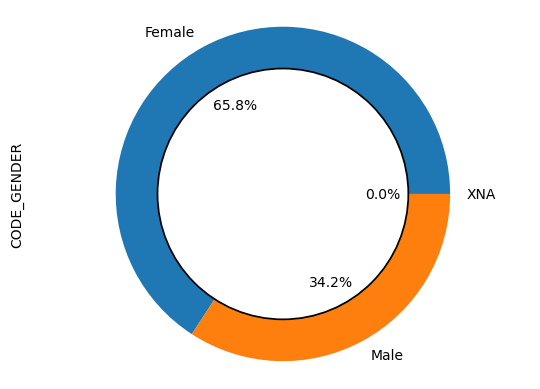

In [9]:
# The slices will be ordered and plotted counter-clockwise.
labels = ['Female', 'Male', 'XNA']


df['CODE_GENDER'].value_counts().plot.pie(center=(0, 0), radius=1.0, autopct='%1.1f%%', labels=labels)

        
#draw a circle at the center of pie to make it look like a donut
centre_circle = plt.Circle((0,0),0.75,color='black', fc='white',linewidth=1.25)
fig = plt.gcf()
fig.gca().add_artist(centre_circle)


# Set aspect ratio to be equal so that pie is drawn as a circle.
plt.axis('equal')
plt.show()  

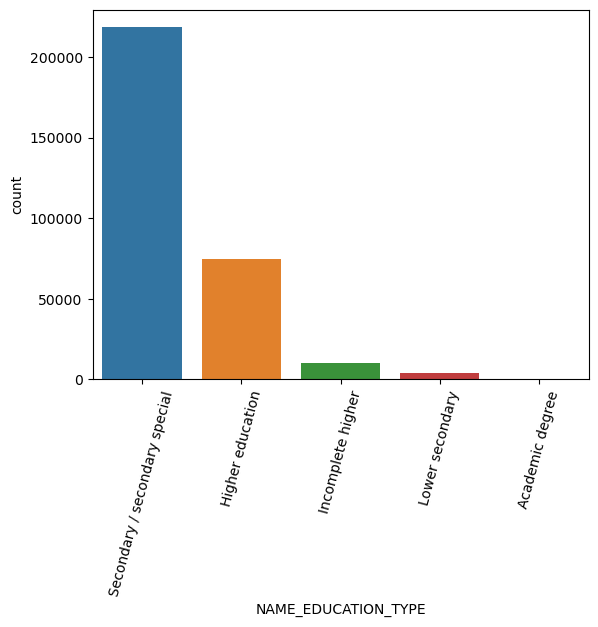

In [10]:
# Distribution of the type of education 
sns.countplot(x=df['NAME_EDUCATION_TYPE'])
plt.xticks(rotation=75)
plt.show();

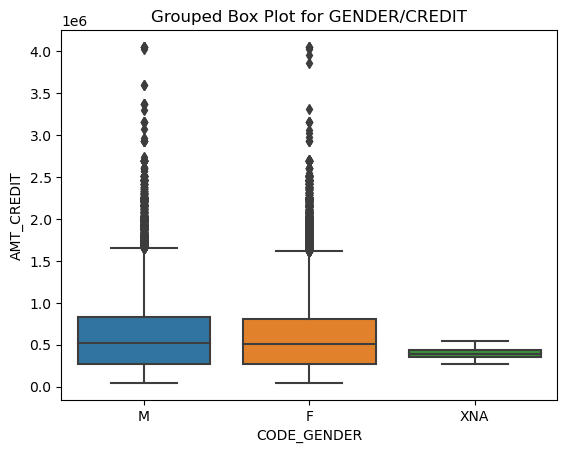

In [11]:
sns.boxplot(x='CODE_GENDER', y='AMT_CREDIT', data=df).set_title('Grouped Box Plot for GENDER/CREDIT');

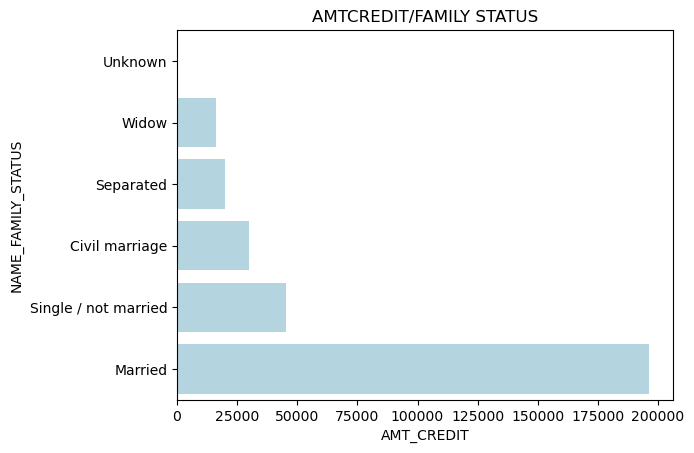

In [12]:
res = df.groupby(['NAME_FAMILY_STATUS'])['AMT_CREDIT'].count().reset_index().sort_values('AMT_CREDIT')
ax=sns.barplot(x='AMT_CREDIT', y='NAME_FAMILY_STATUS', color='lightblue', data=res).set_title('AMTCREDIT/FAMILY STATUS');

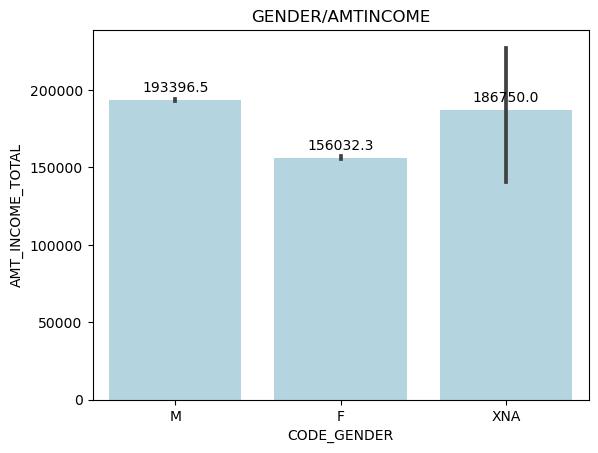

In [13]:
g= sns.barplot(x='CODE_GENDER', y='AMT_INCOME_TOTAL', color='lightblue', data=df)
for p in g.patches:
    g.annotate(format(p.get_height(), '.1f'), 
                   (p.get_x() + p.get_width() / 2., p.get_height()), 
                   ha = 'center', va = 'center', 
                   xytext = (0, 9), 
                   textcoords = 'offset points')
    g.set_title('GENDER/AMTINCOME')

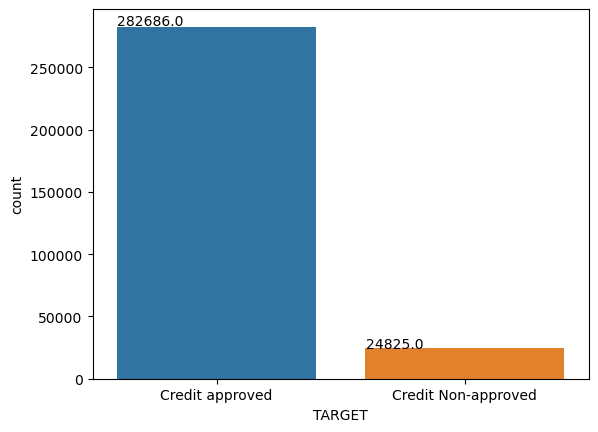

In [14]:
s = sns.countplot(x = 'TARGET',data = df)
for p in s.patches:
    s.annotate(str(p.get_height()), (p.get_x() * 1.005, p.get_height() * 1.005))
    s.set_xticklabels(['Credit approved','Credit Non-approved']);

0 means actually the credit is given and 1 means the credit is rejected.

In [15]:
r1 = df.groupby(['CNT_CHILDREN'])['AMT_CREDIT'].count().reset_index().sort_values('AMT_CREDIT')

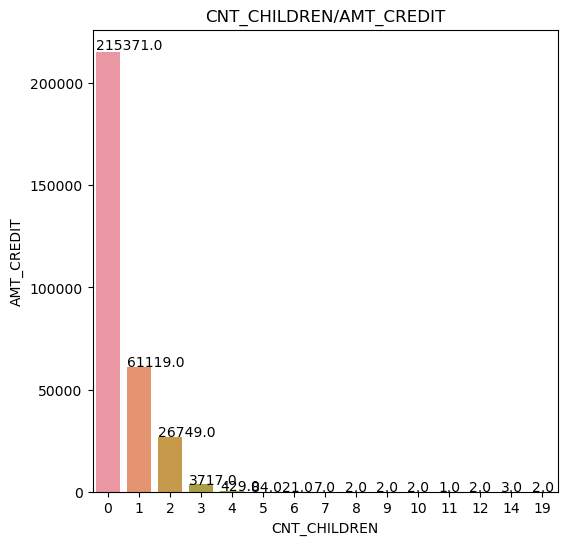

In [16]:
plt.figure(figsize=(6, 6))
s = sns.barplot(x='CNT_CHILDREN', y='AMT_CREDIT', data=r1)
for p in s.patches:
    s.annotate(str(p.get_height()), (p.get_x() * 1.005, p.get_height() * 1.005))
    plt.title("CNT_CHILDREN/AMT_CREDIT")

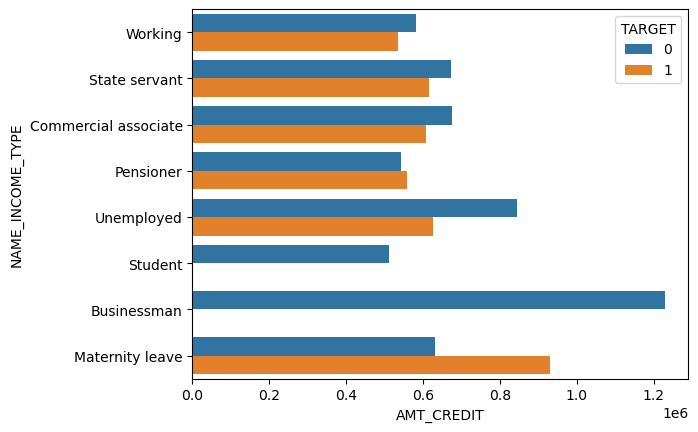

In [17]:
sns.barplot(data=df, y='NAME_INCOME_TYPE', x='AMT_CREDIT' , hue='TARGET',  errorbar=None)
plt.show()

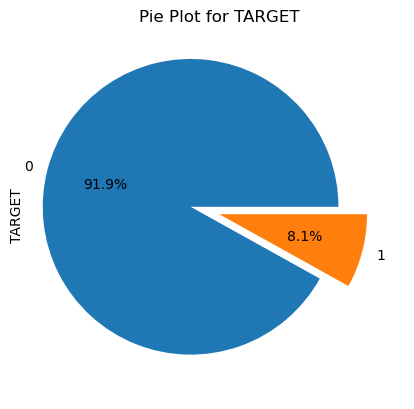

In [18]:
df['TARGET'].value_counts().plot.pie(center=(0, 0), explode = [0.2, 0], radius=1.0, autopct='%1.1f%%').set_title('Pie Plot for TARGET');

### Hence the data is imbalanced

In [19]:
df['DAYS_BIRTH'].head()

0    -9461
1   -16765
2   -19046
3   -19005
4   -19932
Name: DAYS_BIRTH, dtype: int64

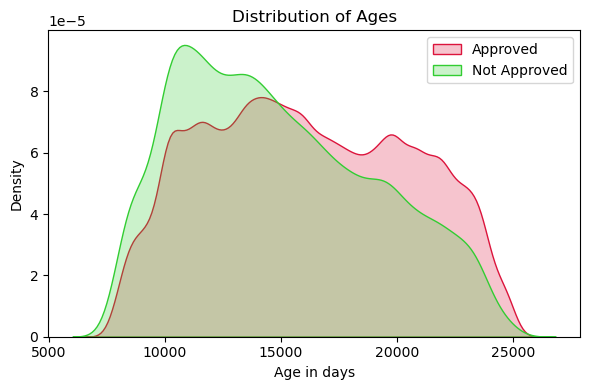

In [20]:
# Plotting the KDE Plot
fig, ax = plt.subplots(figsize=(6, 4))

sns.kdeplot(abs(df.loc[df['TARGET'] == 0, 'DAYS_BIRTH']), color='crimson', fill=True, label = 'Approved', ax=ax)
sns.kdeplot(abs(df.loc[df['TARGET'] == 1, 'DAYS_BIRTH']), color='limegreen', fill='True', label = 'Not Approved', ax=ax)

# Labeling of plot
plt.xlabel('Age in days')
plt.ylabel('Density'); 
plt.title('Distribution of Ages')
ax.legend()
plt.tight_layout()
plt.show()

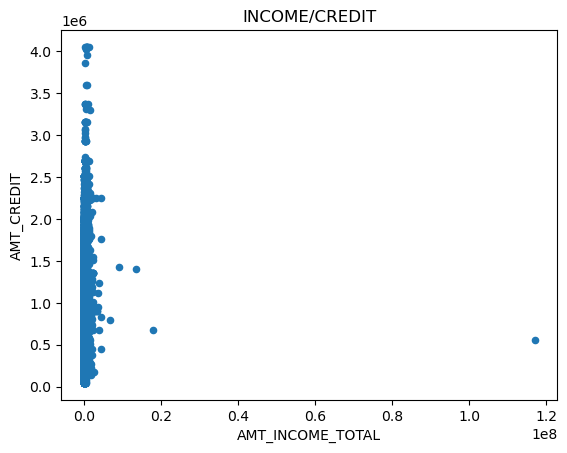

In [21]:
df.plot(kind = 'scatter', x="AMT_INCOME_TOTAL", y="AMT_CREDIT", title="INCOME/CREDIT");

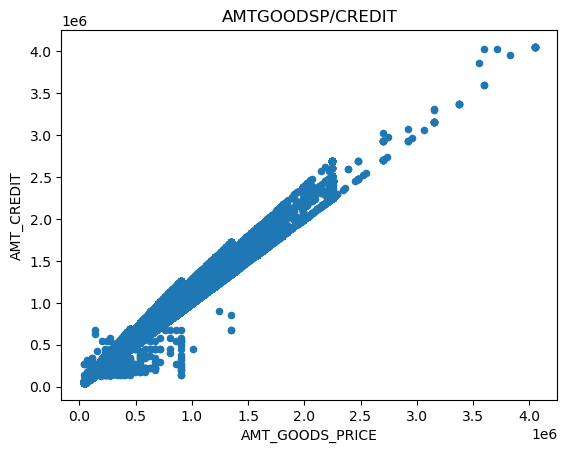

In [22]:
df.plot(kind = 'scatter', x="AMT_GOODS_PRICE", y="AMT_CREDIT", title="AMTGOODSP/CREDIT");

***There is positive correlation between AMT GOODS Price and CREDIT.***

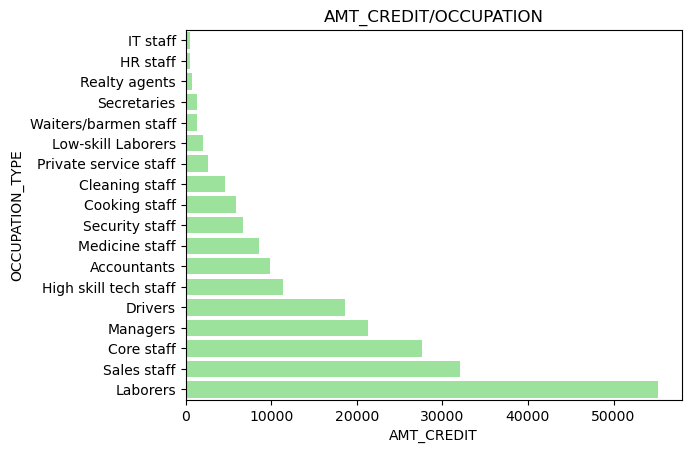

In [23]:
result = df.groupby(["OCCUPATION_TYPE"])['AMT_CREDIT'].count().reset_index().sort_values('AMT_CREDIT')
sns.barplot(x='AMT_CREDIT', y='OCCUPATION_TYPE', color='lightgreen', data=result)
plt.title("AMT_CREDIT/OCCUPATION");

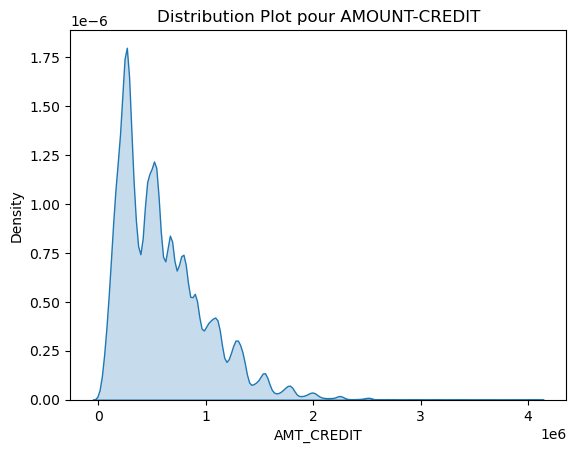

In [24]:
sns.kdeplot(df['AMT_CREDIT'], fill=True).set_title('Distribution Plot pour AMOUNT-CREDIT');

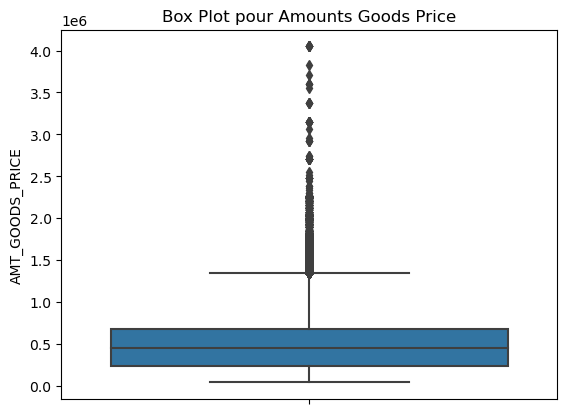

In [25]:
sns.boxplot(y='AMT_GOODS_PRICE', data=df).set_title('Box Plot pour Amounts Goods Price');

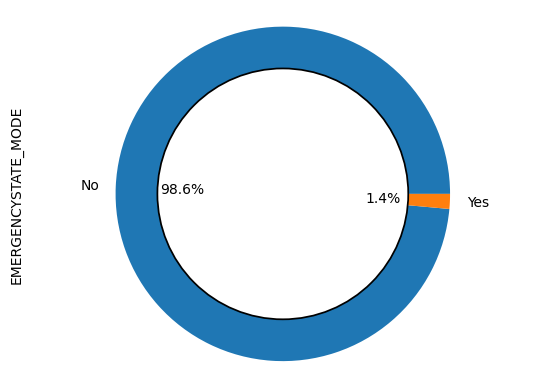

In [26]:
# The slices will be ordered and plotted counter-clockwise.

df['EMERGENCYSTATE_MODE'].value_counts().plot.pie(center=(0, 0), radius=1.0, 
                                                  explode = [0, 0], autopct='%1.1f%%')

        
#draw a circle at the center of pie to make it look like a donut
centre_circle = plt.Circle((0,0),0.75,color='black', fc='white',linewidth=1.25)
fig = plt.gcf()
fig.gca().add_artist(centre_circle)


# Set aspect ratio to be equal so that pie is drawn as a circle.
plt.axis('equal')
plt.show()  

**Get rid of the outliers**

In [27]:
# In order to remove the data we use capping;
def cap_data(df):
    for col in df.columns:
        if (((df[col].dtype)=='float64') | ((df[col].dtype)=='int64')):
            percentiles = df[col].quantile([0.01,0.99]).values
            df[col][df[col] <= percentiles[0]] = percentiles[0]
            df[col][df[col] >= percentiles[1]] = percentiles[1]
        else:
            df[col]=df[col]
    return df

df=cap_data(df)

In [28]:
df.shape

(307511, 122)

In [29]:
df.isnull().sum()

SK_ID_CURR                        0
TARGET                            0
NAME_CONTRACT_TYPE                0
CODE_GENDER                       0
FLAG_OWN_CAR                      0
                              ...  
AMT_REQ_CREDIT_BUREAU_DAY     41519
AMT_REQ_CREDIT_BUREAU_WEEK    41519
AMT_REQ_CREDIT_BUREAU_MON     41519
AMT_REQ_CREDIT_BUREAU_QRT     41519
AMT_REQ_CREDIT_BUREAU_YEAR    41519
Length: 122, dtype: int64

In [30]:
X1=df.select_dtypes('object')

In [31]:
X1.columns

Index(['NAME_CONTRACT_TYPE', 'CODE_GENDER', 'FLAG_OWN_CAR', 'FLAG_OWN_REALTY',
       'NAME_TYPE_SUITE', 'NAME_INCOME_TYPE', 'NAME_EDUCATION_TYPE',
       'NAME_FAMILY_STATUS', 'NAME_HOUSING_TYPE', 'OCCUPATION_TYPE',
       'WEEKDAY_APPR_PROCESS_START', 'ORGANIZATION_TYPE', 'FONDKAPREMONT_MODE',
       'HOUSETYPE_MODE', 'WALLSMATERIAL_MODE', 'EMERGENCYSTATE_MODE'],
      dtype='object')

In [32]:
X1['NAME_INCOME_TYPE'].value_counts()

Working                 158774
Commercial associate     71617
Pensioner                55362
State servant            21703
Unemployed                  22
Student                     18
Businessman                 10
Maternity leave              5
Name: NAME_INCOME_TYPE, dtype: int64

In [33]:
X1['NAME_EDUCATION_TYPE'].value_counts()

Secondary / secondary special    218391
Higher education                  74863
Incomplete higher                 10277
Lower secondary                    3816
Academic degree                     164
Name: NAME_EDUCATION_TYPE, dtype: int64

In [34]:
X1['EMERGENCYSTATE_MODE'].value_counts()

No     159428
Yes      2328
Name: EMERGENCYSTATE_MODE, dtype: int64

In [35]:
X1.isnull().sum()

NAME_CONTRACT_TYPE                 0
CODE_GENDER                        0
FLAG_OWN_CAR                       0
FLAG_OWN_REALTY                    0
NAME_TYPE_SUITE                 1292
NAME_INCOME_TYPE                   0
NAME_EDUCATION_TYPE                0
NAME_FAMILY_STATUS                 0
NAME_HOUSING_TYPE                  0
OCCUPATION_TYPE                96391
WEEKDAY_APPR_PROCESS_START         0
ORGANIZATION_TYPE                  0
FONDKAPREMONT_MODE            210295
HOUSETYPE_MODE                154297
WALLSMATERIAL_MODE            156341
EMERGENCYSTATE_MODE           145755
dtype: int64

In [36]:
X1= X1.drop(columns=['FONDKAPREMONT_MODE','HOUSETYPE_MODE', 'WALLSMATERIAL_MODE', 'EMERGENCYSTATE_MODE'])

In [37]:
X1.isnull().sum()

NAME_CONTRACT_TYPE                0
CODE_GENDER                       0
FLAG_OWN_CAR                      0
FLAG_OWN_REALTY                   0
NAME_TYPE_SUITE                1292
NAME_INCOME_TYPE                  0
NAME_EDUCATION_TYPE               0
NAME_FAMILY_STATUS                0
NAME_HOUSING_TYPE                 0
OCCUPATION_TYPE               96391
WEEKDAY_APPR_PROCESS_START        0
ORGANIZATION_TYPE                 0
dtype: int64

In [38]:
df['CODE_GENDER'].unique()

array(['M', 'F', 'XNA'], dtype=object)

In [39]:
col=['OCCUPATION_TYPE', 'NAME_TYPE_SUITE']
for x in col:
    X1[x]=X1[x].fillna(X1[x].mode()[0])

In [40]:
X1.head()

,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,NAME_TYPE_SUITE,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,OCCUPATION_TYPE,WEEKDAY_APPR_PROCESS_START,ORGANIZATION_TYPE
0,Cash loans,M,N,Y,Unaccompanied,Working,Secondary / secondary special,Single / not married,House / apartment,Laborers,WEDNESDAY,Business Entity Type 3
1,Cash loans,F,N,N,Family,State servant,Higher education,Married,House / apartment,Core staff,MONDAY,School
2,Revolving loans,M,Y,Y,Unaccompanied,Working,Secondary / secondary special,Single / not married,House / apartment,Laborers,MONDAY,Government
3,Cash loans,F,N,Y,Unaccompanied,Working,Secondary / secondary special,Civil marriage,House / apartment,Laborers,WEDNESDAY,Business Entity Type 3
4,Cash loans,M,N,Y,Unaccompanied,Working,Secondary / secondary special,Single / not married,House / apartment,Core staff,THURSDAY,Religion


In [41]:
X1.shape

(307511, 12)

In [42]:
X2 = df._get_numeric_data()

In [43]:
X2.columns

Index(['SK_ID_CURR', 'TARGET', 'CNT_CHILDREN', 'AMT_INCOME_TOTAL',
       'AMT_CREDIT', 'AMT_ANNUITY', 'AMT_GOODS_PRICE',
       'REGION_POPULATION_RELATIVE', 'DAYS_BIRTH', 'DAYS_EMPLOYED',
       ...
       'FLAG_DOCUMENT_18', 'FLAG_DOCUMENT_19', 'FLAG_DOCUMENT_20',
       'FLAG_DOCUMENT_21', 'AMT_REQ_CREDIT_BUREAU_HOUR',
       'AMT_REQ_CREDIT_BUREAU_DAY', 'AMT_REQ_CREDIT_BUREAU_WEEK',
       'AMT_REQ_CREDIT_BUREAU_MON', 'AMT_REQ_CREDIT_BUREAU_QRT',
       'AMT_REQ_CREDIT_BUREAU_YEAR'],
      dtype='object', length=106)

In [44]:
X2.shape

(307511, 106)

In [45]:
X2 = X2.drop(columns=['REG_REGION_NOT_LIVE_REGION', 
                      'REG_REGION_NOT_WORK_REGION', 'LIVE_REGION_NOT_WORK_REGION', 
                      'REG_CITY_NOT_LIVE_CITY', 'REG_CITY_NOT_WORK_CITY', 
                      'LIVE_CITY_NOT_WORK_CITY', 'EXT_SOURCE_1', 
                      'EXT_SOURCE_2','EXT_SOURCE_3', 'APARTMENTS_AVG', 
                      'BASEMENTAREA_AVG', 'YEARS_BEGINEXPLUATATION_AVG', 
                      'YEARS_BUILD_AVG', 'COMMONAREA_AVG','ELEVATORS_AVG', 
                      'ENTRANCES_AVG', 'FLOORSMAX_AVG', 'FLOORSMIN_AVG', 'LANDAREA_AVG', 
                      'LIVINGAPARTMENTS_AVG'])

In [46]:
X2.columns

Index(['SK_ID_CURR', 'TARGET', 'CNT_CHILDREN', 'AMT_INCOME_TOTAL',
       'AMT_CREDIT', 'AMT_ANNUITY', 'AMT_GOODS_PRICE',
       'REGION_POPULATION_RELATIVE', 'DAYS_BIRTH', 'DAYS_EMPLOYED',
       'DAYS_REGISTRATION', 'DAYS_ID_PUBLISH', 'OWN_CAR_AGE', 'FLAG_MOBIL',
       'FLAG_EMP_PHONE', 'FLAG_WORK_PHONE', 'FLAG_CONT_MOBILE', 'FLAG_PHONE',
       'FLAG_EMAIL', 'CNT_FAM_MEMBERS', 'REGION_RATING_CLIENT',
       'REGION_RATING_CLIENT_W_CITY', 'HOUR_APPR_PROCESS_START',
       'LIVINGAREA_AVG', 'NONLIVINGAPARTMENTS_AVG', 'NONLIVINGAREA_AVG',
       'APARTMENTS_MODE', 'BASEMENTAREA_MODE', 'YEARS_BEGINEXPLUATATION_MODE',
       'YEARS_BUILD_MODE', 'COMMONAREA_MODE', 'ELEVATORS_MODE',
       'ENTRANCES_MODE', 'FLOORSMAX_MODE', 'FLOORSMIN_MODE', 'LANDAREA_MODE',
       'LIVINGAPARTMENTS_MODE', 'LIVINGAREA_MODE', 'NONLIVINGAPARTMENTS_MODE',
       'NONLIVINGAREA_MODE', 'APARTMENTS_MEDI', 'BASEMENTAREA_MEDI',
       'YEARS_BEGINEXPLUATATION_MEDI', 'YEARS_BUILD_MEDI', 'COMMONAREA_MEDI',
       

In [47]:
col=['DAYS_LAST_PHONE_CHANGE', 'FLAG_DOCUMENT_2', 'AMT_GOODS_PRICE', 'OBS_60_CNT_SOCIAL_CIRCLE', 
       'FLAG_DOCUMENT_3', 'FLAG_DOCUMENT_4', 'FLAG_DOCUMENT_5', 'FLOORSMIN_MODE', 'FLOORSMIN_MEDI',
       'FLAG_DOCUMENT_6', 'FLAG_DOCUMENT_7', 'FLAG_DOCUMENT_8', 'YEARS_BUILD_MEDI', 'YEARS_BUILD_MODE',
       'FLAG_DOCUMENT_9', 'FLAG_DOCUMENT_10', 'FLAG_DOCUMENT_11', 'LIVINGAPARTMENTS_MEDI', 'LIVINGAPARTMENTS_MODE',
       'FLAG_DOCUMENT_12', 'FLAG_DOCUMENT_13', 'FLAG_DOCUMENT_14', 'BASEMENTAREA_MODE', 'LANDAREA_MODE', 'LANDAREA_MEDI',
       'FLAG_DOCUMENT_15', 'FLAG_DOCUMENT_16', 'FLAG_DOCUMENT_17', 'OWN_CAR_AGE', 'NONLIVINGAPARTMENTS_AVG',
       'FLAG_DOCUMENT_18', 'FLAG_DOCUMENT_19', 'FLAG_DOCUMENT_20', 'ELEVATORS_MEDI', 'NONLIVINGAREA_MEDI',
       'FLAG_DOCUMENT_21', 'AMT_REQ_CREDIT_BUREAU_HOUR', 'NONLIVINGAREA_AVG', 'NONLIVINGAREA_MODE', 'BASEMENTAREA_MEDI',
       'AMT_REQ_CREDIT_BUREAU_DAY', 'AMT_REQ_CREDIT_BUREAU_WEEK', 'ENTRANCES_MODE', 'ENTRANCES_MEDI', 'APARTMENTS_MODE', 
       'AMT_REQ_CREDIT_BUREAU_MON', 'AMT_REQ_CREDIT_BUREAU_QRT', 'APARTMENTS_MEDI', 'ELEVATORS_MODE', 'TOTALAREA_MODE',
       'AMT_REQ_CREDIT_BUREAU_YEAR', 'OBS_60_CNT_SOCIAL_CIRCLE', 'FLOORSMAX_MODE', 'FLOORSMAX_MEDI', 'LIVINGAREA_AVG',
     'DEF_60_CNT_SOCIAL_CIRCLE', 'OBS_30_CNT_SOCIAL_CIRCLE', 'LIVINGAREA_MODE', 'LIVINGAREA_MEDI', 'AMT_ANNUITY',
     'NONLIVINGAPARTMENTS_MEDI', 'NONLIVINGAPARTMENTS_MODE', 'COMMONAREA_MODE', 'COMMONAREA_MEDI',
    'DEF_30_CNT_SOCIAL_CIRCLE', 'YEARS_BEGINEXPLUATATION_MODE', 'YEARS_BEGINEXPLUATATION_MEDI', 'CNT_FAM_MEMBERS']
for x in col:
    X2[x]=X2[x].fillna(X2[x].mean())

In [48]:
#Remove of all the null values
X2.isnull().sum().sort_values()

SK_ID_CURR                    0
FLAG_DOCUMENT_3               0
FLAG_DOCUMENT_2               0
DAYS_LAST_PHONE_CHANGE        0
DEF_60_CNT_SOCIAL_CIRCLE      0
                             ..
NONLIVINGAREA_AVG             0
NONLIVINGAPARTMENTS_AVG       0
LIVINGAREA_AVG                0
ELEVATORS_MODE                0
AMT_REQ_CREDIT_BUREAU_YEAR    0
Length: 86, dtype: int64

### Now we concate the two dataframes

In [49]:
df1 = pd.concat([X1, X2], axis=1, join="inner")

In [50]:
df1.head()

,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,NAME_TYPE_SUITE,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,OCCUPATION_TYPE,...,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
0,Cash loans,M,N,Y,Unaccompanied,Working,Secondary / secondary special,Single / not married,House / apartment,Laborers,...,0,0,0,0,0.0,0.0,0.000000,0.000000,0.00000,1.000000
1,Cash loans,F,N,N,Family,State servant,Higher education,Married,House / apartment,Core staff,...,0,0,0,0,0.0,0.0,0.000000,0.000000,0.00000,0.000000
2,Revolving loans,M,Y,Y,Unaccompanied,Working,Secondary / secondary special,Single / not married,House / apartment,Laborers,...,0,0,0,0,0.0,0.0,0.000000,0.000000,0.00000,0.000000
3,Cash loans,F,N,Y,Unaccompanied,Working,Secondary / secondary special,Civil marriage,House / apartment,Laborers,...,0,0,0,0,0.0,0.0,0.032091,0.236218,0.25297,1.893237
4,Cash loans,M,N,Y,Unaccompanied,Working,Secondary / secondary special,Single / not married,House / apartment,Core staff,...,0,0,0,0,0.0,0.0,0.000000,0.000000,0.00000,0.000000


In [51]:
df1.shape

(307511, 98)

**Create two new columns**

In [52]:
df1['NEW_DAYS_EMPLOYED'] = df1['DAYS_EMPLOYED'] /df1['DAYS_BIRTH']
df1['NEW_INCOME_CREDIT'] = df1['AMT_INCOME_TOTAL'] / df1['AMT_CREDIT']

In [53]:
df1.select_dtypes('object').columns

Index(['NAME_CONTRACT_TYPE', 'CODE_GENDER', 'FLAG_OWN_CAR', 'FLAG_OWN_REALTY',
       'NAME_TYPE_SUITE', 'NAME_INCOME_TYPE', 'NAME_EDUCATION_TYPE',
       'NAME_FAMILY_STATUS', 'NAME_HOUSING_TYPE', 'OCCUPATION_TYPE',
       'WEEKDAY_APPR_PROCESS_START', 'ORGANIZATION_TYPE'],
      dtype='object')

### Use One hot encoding on the remaining categorical data

In [54]:
cols=['NAME_CONTRACT_TYPE','NAME_TYPE_SUITE', 'NAME_INCOME_TYPE', 'CODE_GENDER',
       'NAME_FAMILY_STATUS', 'NAME_HOUSING_TYPE', 'OCCUPATION_TYPE',
       'WEEKDAY_APPR_PROCESS_START', 'ORGANIZATION_TYPE']

In [55]:
df1=pd.get_dummies(df1, columns= cols, drop_first=True)

In [56]:
df1.head()

,FLAG_OWN_CAR,FLAG_OWN_REALTY,NAME_EDUCATION_TYPE,SK_ID_CURR,TARGET,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,...,ORGANIZATION_TYPE_Trade: type 4,ORGANIZATION_TYPE_Trade: type 5,ORGANIZATION_TYPE_Trade: type 6,ORGANIZATION_TYPE_Trade: type 7,ORGANIZATION_TYPE_Transport: type 1,ORGANIZATION_TYPE_Transport: type 2,ORGANIZATION_TYPE_Transport: type 3,ORGANIZATION_TYPE_Transport: type 4,ORGANIZATION_TYPE_University,ORGANIZATION_TYPE_XNA
0,N,Y,Secondary / secondary special,103590.2,1,0,202500.0,406597.5,24700.5,351000.0,...,0,0,0,0,0,0,0,0,0,0
1,N,N,Higher education,103590.2,0,0,270000.0,1293502.5,35698.5,1129500.0,...,0,0,0,0,0,0,0,0,0,0
2,Y,Y,Secondary / secondary special,103590.2,0,0,67500.0,135000.0,6750.0,135000.0,...,0,0,0,0,0,0,0,0,0,0
3,N,Y,Secondary / secondary special,103590.2,0,0,135000.0,312682.5,29686.5,297000.0,...,0,0,0,0,0,0,0,0,0,0
4,N,Y,Secondary / secondary special,103590.2,0,0,121500.0,513000.0,21865.5,513000.0,...,0,0,0,0,0,0,0,0,0,0


In [57]:
df1.shape

(307511, 197)

Now we create a dataframe which does not have the TARGET variable. We also drop some more column which we think is not required

In [58]:
X = df1.drop(columns=['TARGET','FLAG_DOCUMENT_2', 'SK_ID_CURR',
                     'FLAG_DOCUMENT_3', 'FLAG_DOCUMENT_4', 'FLAG_DOCUMENT_5', 'FLAG_DOCUMENT_6',
                     'FLAG_DOCUMENT_7', 'FLAG_DOCUMENT_8', 'FLAG_DOCUMENT_9', 
                     'FLAG_DOCUMENT_10', 'FLAG_DOCUMENT_11', 'FLAG_DOCUMENT_12',
                     'FLAG_DOCUMENT_13', 'FLAG_DOCUMENT_14', 'FLAG_DOCUMENT_15',
                     'FLAG_DOCUMENT_16', 'FLAG_DOCUMENT_17', 'FLAG_DOCUMENT_18', 
                     'FLAG_DOCUMENT_19', 'FLAG_DOCUMENT_20', 'FLAG_DOCUMENT_21'])

In [59]:
y = df1['TARGET']

In [60]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2,random_state=42)

In [61]:
X_train.shape, X_test.shape

((246008, 175), (61503, 175))

In [62]:
y_train.value_counts()

0    226132
1     19876
Name: TARGET, dtype: int64

### Ordinal encoding

In [63]:
le = OrdinalEncoder()
X_train[['FLAG_OWN_CAR', 'FLAG_OWN_REALTY','NAME_EDUCATION_TYPE']] = le.fit_transform(X_train[['FLAG_OWN_CAR', 'FLAG_OWN_REALTY', 'NAME_EDUCATION_TYPE']])

In [64]:
# Ordinal encoding on the X_test data
X_test[['FLAG_OWN_CAR', 'FLAG_OWN_REALTY','NAME_EDUCATION_TYPE']] = le.transform(X_test[['FLAG_OWN_CAR', 'FLAG_OWN_REALTY', 'NAME_EDUCATION_TYPE']])

In [65]:
X_train.head()

,FLAG_OWN_CAR,FLAG_OWN_REALTY,NAME_EDUCATION_TYPE,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,...,ORGANIZATION_TYPE_Trade: type 4,ORGANIZATION_TYPE_Trade: type 5,ORGANIZATION_TYPE_Trade: type 6,ORGANIZATION_TYPE_Trade: type 7,ORGANIZATION_TYPE_Transport: type 1,ORGANIZATION_TYPE_Transport: type 2,ORGANIZATION_TYPE_Transport: type 3,ORGANIZATION_TYPE_Transport: type 4,ORGANIZATION_TYPE_University,ORGANIZATION_TYPE_XNA
123473,1.0,0.0,4.0,0,171000.0,555273.0,16366.5,463500.0,0.035792,-23349,...,0,0,0,0,0,0,0,0,0,1
10118,0.0,1.0,4.0,1,157500.0,198085.5,23638.5,171000.0,0.010032,-10921,...,0,0,0,0,0,0,0,0,0,0
64716,1.0,1.0,3.0,0,135000.0,776304.0,25173.0,648000.0,0.035792,-23213,...,0,0,0,0,0,0,0,0,0,0
234940,1.0,1.0,4.0,1,164133.0,900000.0,36787.5,900000.0,0.030755,-10703,...,0,0,0,0,0,0,0,0,0,0
236051,0.0,1.0,4.0,0,225000.0,533668.5,21294.0,477000.0,0.025164,-15798,...,0,0,0,0,0,0,0,0,0,0


In [66]:
X_train.shape

(246008, 175)

In [67]:
X_train.dtypes

FLAG_OWN_CAR                           float64
FLAG_OWN_REALTY                        float64
NAME_EDUCATION_TYPE                    float64
CNT_CHILDREN                             int64
AMT_INCOME_TOTAL                       float64
                                        ...   
ORGANIZATION_TYPE_Transport: type 2      uint8
ORGANIZATION_TYPE_Transport: type 3      uint8
ORGANIZATION_TYPE_Transport: type 4      uint8
ORGANIZATION_TYPE_University             uint8
ORGANIZATION_TYPE_XNA                    uint8
Length: 175, dtype: object

### Use Random Sampler  for balancing the dataset

In [68]:
#Undersampling
nm= RandomUnderSampler()
X_train, y_train=nm.fit_resample(X_train, y_train)

In [69]:
X_train.shape

(39752, 175)

In [70]:
#X_test, y_test=nm.fit_resample(X_test, y_test)

In [71]:
X_test.shape

(61503, 175)

### Feature Selection

**In order to select features of the data we use XGB classifier**

In [72]:
model = XGBClassifier(eval_metric='logloss')
model.fit(X_train, y_train)
# feature importance
print(model.feature_importances_)

[0.01210993 0.00513136 0.03610077 0.00517347 0.00577039 0.00995331
 0.0089277  0.01325238 0.00627242 0.01094295 0.01105774 0.00621515
 0.00791772 0.00952359 0.         0.         0.00879512 0.
 0.00505486 0.00476962 0.00559043 0.01818483 0.02514847 0.00499237
 0.00469963 0.00482596 0.00532415 0.00627185 0.00551471 0.00548018
 0.00487619 0.00490378 0.00461478 0.00495387 0.00530079 0.00564284
 0.00451369 0.00618185 0.00630647 0.0061765  0.00645894 0.00611608
 0.00574103 0.00594069 0.00651474 0.00628361 0.00690648 0.00678355
 0.01479193 0.00702765 0.00603879 0.00655129 0.0063466  0.00750018
 0.00735765 0.00571384 0.0049367  0.01346682 0.00662788 0.00572866
 0.00790987 0.         0.         0.00729804 0.00570876 0.0061376
 0.00640347 0.00637369 0.00589165 0.02236166 0.00667871 0.
 0.         0.00491176 0.00528752 0.00547662 0.00493005 0.
 0.         0.00812113 0.         0.00197024 0.02501943 0.02277528
 0.         0.01248361 0.0050161  0.0070758  0.         0.00539733
 0.0033628  0.004887

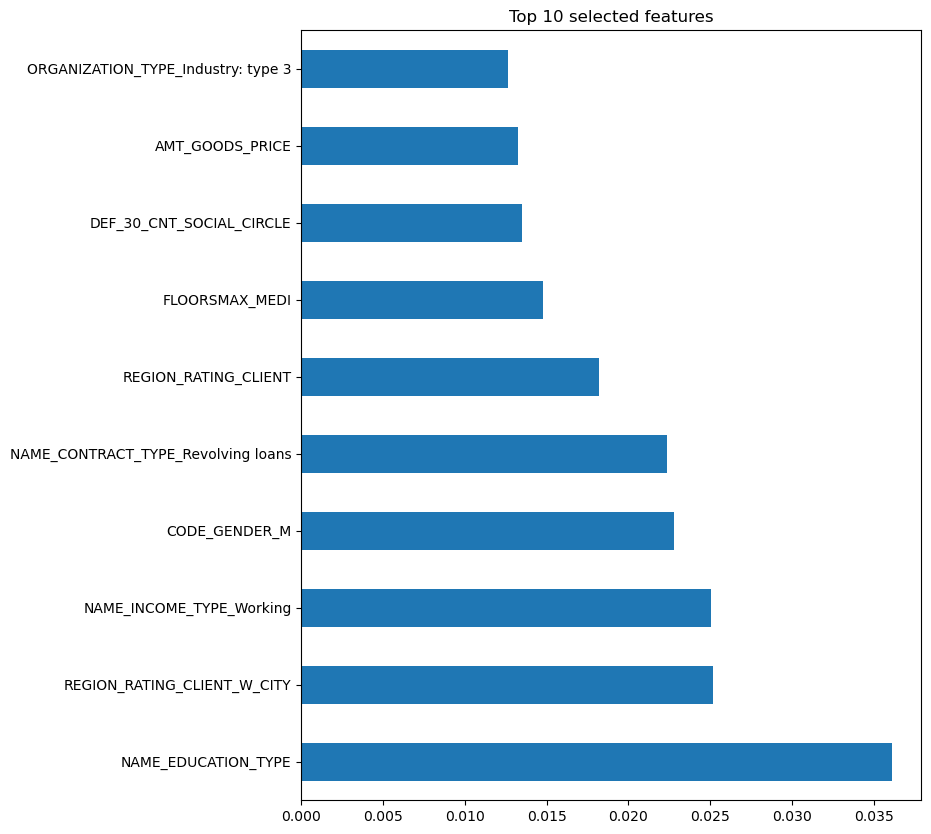

In [73]:
feat_imp = pd.Series(model.feature_importances_, index=X_train.columns)
feat_imp.nlargest(10).plot(kind='barh', figsize=(8,10))
plt.title("Top 10 selected features")
plt.show()

In [74]:
f=feat_imp.nlargest(10).index.tolist()
f

['NAME_EDUCATION_TYPE',
 'REGION_RATING_CLIENT_W_CITY',
 'NAME_INCOME_TYPE_Working',
 'CODE_GENDER_M',
 'NAME_CONTRACT_TYPE_Revolving loans',
 'REGION_RATING_CLIENT',
 'FLOORSMAX_MEDI',
 'DEF_30_CNT_SOCIAL_CIRCLE',
 'AMT_GOODS_PRICE',
 'ORGANIZATION_TYPE_Industry: type 3']

In [75]:
unwanted = []
for col in X_train.columns:
    if col not in feat_imp.nlargest(100):
        unwanted.append(col)

In [76]:
len(unwanted)

75

In [77]:
# We consider only top 100 features
X_train=X_train.drop(columns=unwanted)
X_test=X_test.drop(columns=unwanted)

In [78]:
X_train.shape, X_test.shape

((39752, 100), (61503, 100))

In [79]:
y_train.shape, y_test.shape

((39752,), (61503,))

In [80]:
X_test.head()

,FLAG_OWN_CAR,NAME_EDUCATION_TYPE,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,...,ORGANIZATION_TYPE_Medicine,ORGANIZATION_TYPE_Other,ORGANIZATION_TYPE_Postal,ORGANIZATION_TYPE_Restaurant,ORGANIZATION_TYPE_School,ORGANIZATION_TYPE_Security Ministries,ORGANIZATION_TYPE_Self-employed,ORGANIZATION_TYPE_Trade: type 6,ORGANIZATION_TYPE_Transport: type 3,ORGANIZATION_TYPE_Transport: type 4
245895,1.0,4.0,2,207000.0,465457.5,52641.0,418500.0,0.009630,-13297,-762.0,...,0,0,0,0,0,0,0,0,0,0
98194,1.0,1.0,0,247500.0,1281712.5,48946.5,1179000.0,0.006852,-14778,-1141.0,...,0,0,0,0,0,0,0,0,0,0
36463,1.0,4.0,0,202500.0,495000.0,39109.5,495000.0,0.035792,-17907,-639.0,...,0,0,0,0,0,0,1,0,0,0
249923,0.0,4.0,0,247500.0,254700.0,24939.0,225000.0,0.046220,-19626,-6982.0,...,0,0,0,0,0,0,0,0,0,0
158389,0.0,4.0,0,112500.0,308133.0,15862.5,234000.0,0.018850,-20327,-1105.0,...,0,0,0,0,0,0,0,0,0,0


In [81]:
X_train.corr().shape[0]

100

In [82]:
# Create correlation matrix
corr_matrix = X_train.corr().abs()

# Select upper triangle of correlation matrix
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))

# Find features with correlation greater than 0.95
to_drop = [column for column in upper.columns if any(upper[column] > 0.95)]

# Drop features from the train data
X_train=X_train.drop(columns=to_drop)

In [83]:
# Drop features from the test data
X_test=X_test.drop(columns=to_drop)

In [84]:
X_test.shape

(61503, 87)

In [85]:
X_train.shape

(39752, 87)

In [86]:
X_train.columns

Index(['FLAG_OWN_CAR', 'NAME_EDUCATION_TYPE', 'CNT_CHILDREN',
       'AMT_INCOME_TOTAL', 'AMT_CREDIT', 'AMT_ANNUITY',
       'REGION_POPULATION_RELATIVE', 'DAYS_BIRTH', 'DAYS_EMPLOYED',
       'DAYS_REGISTRATION', 'DAYS_ID_PUBLISH', 'OWN_CAR_AGE',
       'FLAG_WORK_PHONE', 'CNT_FAM_MEMBERS', 'REGION_RATING_CLIENT',
       'NONLIVINGAREA_AVG', 'APARTMENTS_MODE', 'BASEMENTAREA_MODE',
       'YEARS_BEGINEXPLUATATION_MODE', 'FLOORSMAX_MODE', 'FLOORSMIN_MODE',
       'LIVINGAPARTMENTS_MODE', 'LIVINGAREA_MODE', 'NONLIVINGAPARTMENTS_MODE',
       'YEARS_BUILD_MEDI', 'COMMONAREA_MEDI', 'ELEVATORS_MEDI',
       'ENTRANCES_MEDI', 'LANDAREA_MEDI', 'TOTALAREA_MODE',
       'DEF_30_CNT_SOCIAL_CIRCLE', 'OBS_60_CNT_SOCIAL_CIRCLE',
       'DEF_60_CNT_SOCIAL_CIRCLE', 'DAYS_LAST_PHONE_CHANGE',
       'AMT_REQ_CREDIT_BUREAU_WEEK', 'AMT_REQ_CREDIT_BUREAU_MON',
       'AMT_REQ_CREDIT_BUREAU_QRT', 'AMT_REQ_CREDIT_BUREAU_YEAR',
       'NEW_INCOME_CREDIT', 'NAME_CONTRACT_TYPE_Revolving loans',
       'NAME_TY

In [87]:
y_train.shape

(39752,)

### Use Standard scaler

In [88]:
sc = StandardScaler()
X_train_stan = sc.fit_transform(X_train)

In [89]:
X_train_stan.shape, X_test.shape

((39752, 87), (61503, 87))

In [90]:
X_test_stan=sc.transform(X_test)

In [91]:
X_train_stan.shape, X_test_stan.shape

((39752, 87), (61503, 87))

In [92]:
y_train.shape, y_test.shape

((39752,), (61503,))

### Multiple Classifier Testing

In [93]:
models = ["XGBoost", "Gradient_Boosting", 
    "Decision_Tree", "Random_Forest", "AdaBoost", 
    "LogisticRegression"
         ]

classifiers = [
    XGBClassifier(n_estimators=100, eta=0.01, gamma=10),
    GradientBoostingClassifier(n_estimators=100),
    DecisionTreeClassifier(max_depth=5),
    RandomForestClassifier(max_depth=5, n_estimators=100),
    AdaBoostClassifier(n_estimators=100),
    LogisticRegression(penalty = 'l2', C=5)]

In [94]:
import time

scores = []
f2_score = []
recall=[] 

for name, clf in zip(models, classifiers):
    clf.fit(X_train_stan, y_train)
    y_pred = clf.predict(X_test_stan)
    f2 = fbeta_score(y_test, y_pred, beta=2, average='binary')
    Recall=recall_score(y_test, y_pred)
    score = clf.score(X_test_stan, y_test)
    scores.append(score)
    f2_score.append(f2)
    recall.append(Recall)

In [95]:
dg = pd.DataFrame()
dg['model'] = models
dg['score'] = scores
dg['f2_score'] = f2_score
dg['Recall'] = recall
dg =round(dg, 4)

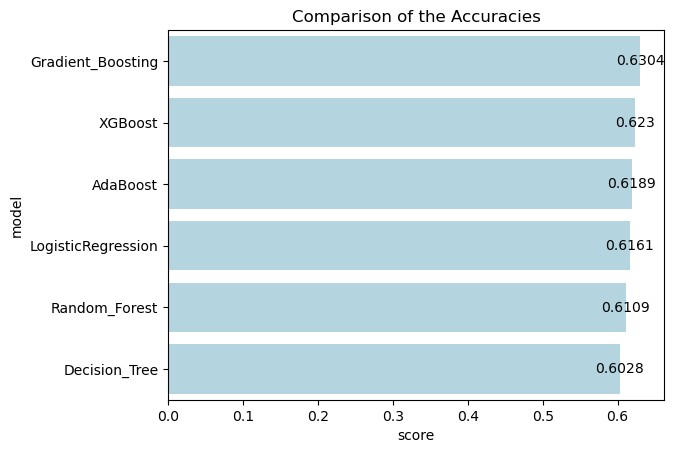

In [96]:
ax=sns.barplot(x="score",y="model",color='lightblue', data=dg, order=dg.sort_values('score', ascending = False).model)
for p in ax.patches:
    ax.annotate(p.get_width(), xy=(p.get_width(), p.get_y()+p.get_height()/2),
            xytext=(0, 0), textcoords='offset points',ha='center', va="center")
plt.title('Comparison of the Accuracies')
plt.show()

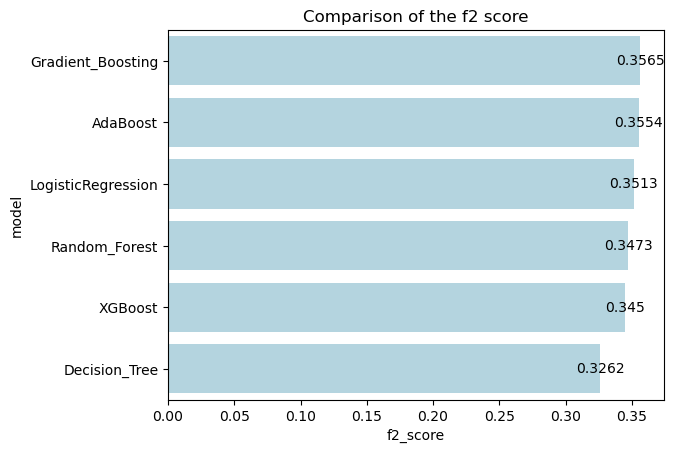

In [97]:
ax=sns.barplot(x="f2_score",y="model",color='lightblue', data=dg, order=dg.sort_values('f2_score',ascending = False).model)
for p in ax.patches:
    ax.annotate(p.get_width(), xy=(p.get_width(), p.get_y()+p.get_height()/2),
            xytext=(0, 0), textcoords='offset points',ha='center', va="center")
    
plt.title('Comparison of the f2 score')
plt.show()

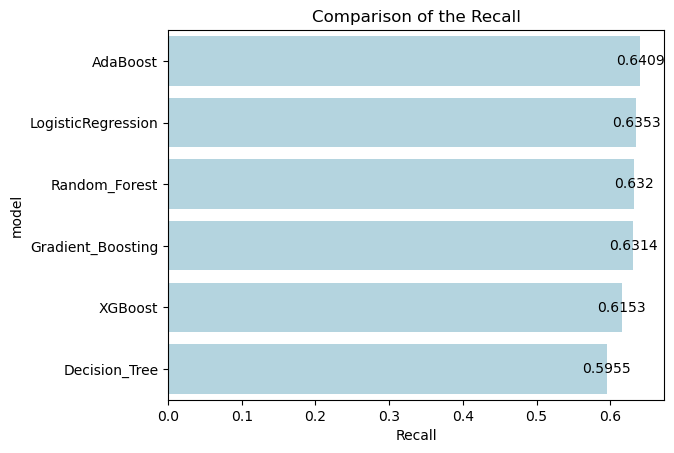

In [98]:
ax=sns.barplot(x="Recall",y="model",color='lightblue', data=dg, order=dg.sort_values('Recall',ascending = False).model)
for p in ax.patches:
    ax.annotate(p.get_width(), xy=(p.get_width(), p.get_y()+p.get_height()/2),
            xytext=(0, 0), textcoords='offset points',ha='center', va="center")
plt.title('Comparison of the Recall')  
plt.show()

***Thus ADABOOST & Decision Tree give the better Recall. Now we are going to study the Algorithms with respect to grid search CV***

Let us check whether we improve the recall with grid search cv.

**Decision Tree+ Grid Search**

In [99]:
tree_para = {'criterion':['gini','entropy'],'max_depth':[4,5,6,7,8,9,10,11,12,15,20,30,40,50,70,90,120,150]}
grid_dt= GridSearchCV(DecisionTreeClassifier(), tree_para, cv=5, scoring='recall')
grid_dt.fit(X_train_stan, y_train)

GridSearchCV(cv=5, estimator=DecisionTreeClassifier(),
             param_grid={'criterion': ['gini', 'entropy'],
                         'max_depth': [4, 5, 6, 7, 8, 9, 10, 11, 12, 15, 20, 30,
                                       40, 50, 70, 90, 120, 150]},
             scoring='recall')

In [100]:
# print best parameter after tuning
print(grid_dt.best_params_)
  
# print how our model looks after hyper-parameter tuning
print(grid_dt.best_estimator_)

#Print recall score
print(grid_dt.best_score_)

{'criterion': 'gini', 'max_depth': 11}
DecisionTreeClassifier(max_depth=11)
0.6253779026359414


In [101]:
y_pred = grid_dt.predict(X_test_stan)
cm = confusion_matrix(y_test, y_pred)
cm

array([[30916, 25638],
       [ 1764,  3185]])

In [102]:
print('Recall for Decision Tree:', recall_score(y_test, y_pred))

Recall for Decision Tree: 0.6435643564356436


In [103]:
# print classification report
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.95      0.55      0.69     56554
           1       0.11      0.64      0.19      4949

    accuracy                           0.55     61503
   macro avg       0.53      0.60      0.44     61503
weighted avg       0.88      0.55      0.65     61503



**Plot the feature importance of the Decision Tree model**

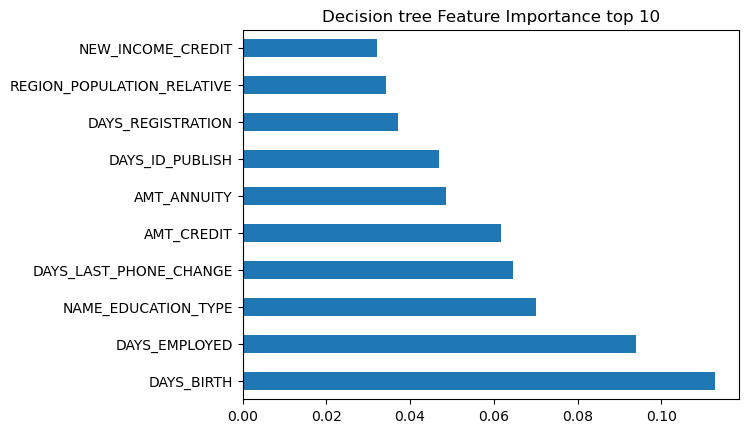

In [104]:
dt=grid_dt.best_estimator_
# Feature importance in decision tree
feat_importances = pd.Series(dt.feature_importances_, index=X_train.columns)
f=feat_importances.nlargest(10)
f.plot(kind='barh')
plt.title('Decision tree Feature Importance top 10')
plt.show()

### Adaboost+GridSearchCV

In [105]:
# defining parameter range
param_grid = {'n_estimators': [75, 100, 150, 200],'learning_rate':[0.01, 0.05, 0.001, 1.0], 'algorithm': ['SAMME', 'SAMME.R']}
  
grid_ada = GridSearchCV(AdaBoostClassifier(), param_grid, scoring='recall', cv=5)
  
# fitting the model for grid search
grid_ada.fit(X_train_stan, y_train)

GridSearchCV(cv=5, estimator=AdaBoostClassifier(),
             param_grid={'algorithm': ['SAMME', 'SAMME.R'],
                         'learning_rate': [0.01, 0.05, 0.001, 1.0],
                         'n_estimators': [75, 100, 150, 200]},
             scoring='recall')

In [106]:
# print best parameter after tuning
print(grid_ada.best_params_)
  
# print how our model looks after hyper-parameter tuning
print(grid_ada.best_estimator_)

# print the best recall score
print(grid_ada.best_score_)

{'algorithm': 'SAMME', 'learning_rate': 0.01, 'n_estimators': 150}
AdaBoostClassifier(algorithm='SAMME', learning_rate=0.01, n_estimators=150)
0.7956326259443454


In [107]:
#confusion matrix
y_pred = grid_ada.predict(X_test_stan)
cm = confusion_matrix(y_test, y_pred)
cm

array([[19113, 37441],
       [  903,  4046]])

In [108]:
print('Recall for AdaBoost:', recall_score(y_test, y_pred))

Recall for AdaBoost: 0.8175388967468176


In [109]:
# print classification report
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.95      0.34      0.50     56554
           1       0.10      0.82      0.17      4949

    accuracy                           0.38     61503
   macro avg       0.53      0.58      0.34     61503
weighted avg       0.89      0.38      0.47     61503



**So we have managed to improve the recall by using GridSearch.**

**Plot the feature importance of the Adaboost model**

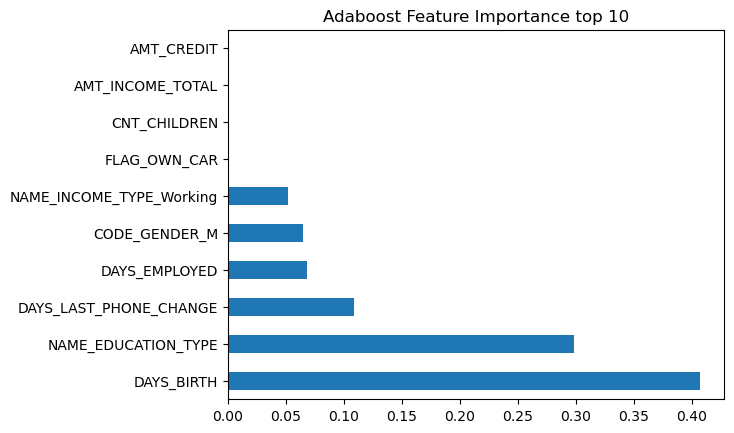

In [110]:
Ab=grid_ada.best_estimator_
feat_importances = pd.Series(Ab.feature_importances_, index=X_train.columns)
f=feat_importances.nlargest(10)
f.plot(kind='barh')
plt.title('Adaboost Feature Importance top 10')
plt.show()

### Now we work with the f2 metric

### Multiple Classifier Testing using GridSearchCV+ f2 score

In [111]:
f2 = make_scorer(fbeta_score, beta=2, average='macro')

In [112]:
model_params = {
    'random_forest': {
        'model': RandomForestClassifier(),
        'params' : {
            'n_estimators': [90,100,110]
        }
    },
    'Adaboost': {
        'model': AdaBoostClassifier(),
        'params' : {
            'n_estimators': [50, 75, 100],
            'learning_rate':[0.01, 0.001, 1.0]
        }
    },
    'Gradient_Boosting': {
        'model': GradientBoostingClassifier(),
        'params' : {
            'n_estimators': [100, 100],
            'learning_rate':[0.01, 1.0]
        }
    },
    'logistic_regression' : {
        'model': LogisticRegression(solver='liblinear',multi_class='auto'),
        'params': {
            'C': [1,5,10]
        }
    }
}

In [113]:
scores = []

for model_name, mp in model_params.items():
    clf =  GridSearchCV(mp['model'], mp['params'], scoring=f2, cv=5, return_train_score=False)
    clf.fit(X_train_stan, y_train)
    scores.append({
        'model': model_name,
        'best_score': clf.best_score_,
        'best_params': clf.best_params_
    })
    
df = pd.DataFrame(scores,columns=['model','best_score','best_params'])
df

,model,best_score,best_params
0,random_forest,0.622915,{'n_estimators': 110}
1,Adaboost,0.628116,"{'learning_rate': 1.0, 'n_estimators': 100}"
2,Gradient_Boosting,0.613820,"{'learning_rate': 1.0, 'n_estimators': 100}"
3,logistic_regression,0.621490,{'C': 1}


### Grid SearchCV + Random Forest Classifier

In [114]:
#Consider the f2 score
f2_score = make_scorer(fbeta_score, beta=2, average='binary')

In [115]:
params = {
    'n_estimators' : [100, 110, 120],
    'max_features':["log2", "sqrt"]
    }

In [116]:
grid_rfc = GridSearchCV(estimator=RandomForestClassifier(), param_grid=params, scoring=f2_score, cv=5, n_jobs=-1)
grid_rfc.fit(X_train_stan, y_train)

GridSearchCV(cv=5, estimator=RandomForestClassifier(), n_jobs=-1,
             param_grid={'max_features': ['log2', 'sqrt'],
                         'n_estimators': [100, 110, 120]},
             scoring=make_scorer(fbeta_score, beta=2, average=binary))

In [117]:
# print best parameter after tuning
print(grid_rfc.best_params_)
  
# print how our model looks after hyper-parameter tuning
print(grid_rfc.best_estimator_)

# print the best recall score
print(grid_rfc.best_score_)

{'max_features': 'sqrt', 'n_estimators': 120}
RandomForestClassifier(n_estimators=120)
0.6022324034516087


In [118]:
y_pred = grid_rfc.predict(X_test_stan)
cm = confusion_matrix(y_test, y_pred)
cm

array([[36543, 20011],
       [ 2011,  2938]])

In [119]:
print('Recall for Random Forest:', recall_score(y_test, y_pred))

Recall for Random Forest: 0.5936552838957365


In [120]:
rf=grid_rfc.best_estimator_

### SHAP for ensemble methods for Random Forest

**SHAP shows the contribution or the importance of each feature on the prediction of the model, it does not evaluate the quality of the prediction itself.**

In [121]:
# We take a small sample of the test data for shap
x_test=X_test.sample(100)

In [122]:
explainer = shap.TreeExplainer(rf)
sv = explainer.shap_values(x_test)
len(sv)

2

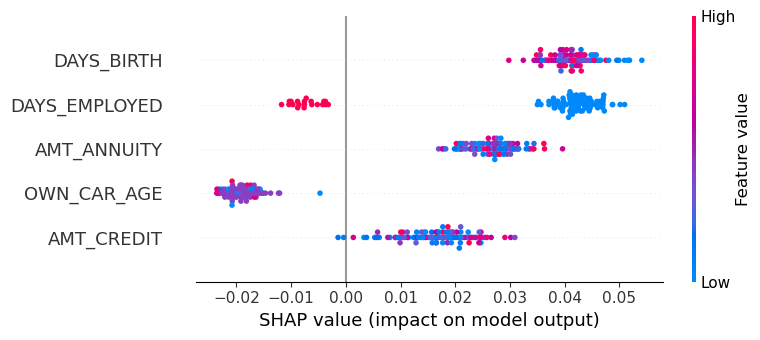

In [123]:
summary_plot(sv[0], x_test, max_display=5)

**Days employed being higher, the model tends to classify the data to CLASS 0.**

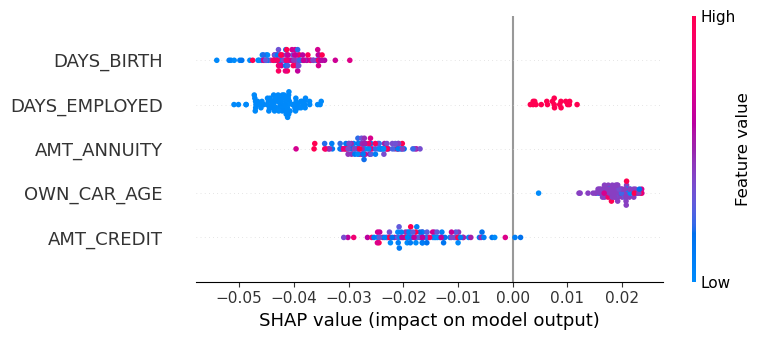

In [124]:
summary_plot(sv[1], x_test, max_display=5)

**Days employed value being higher, the model tends to classify the data to CLASS 1.**

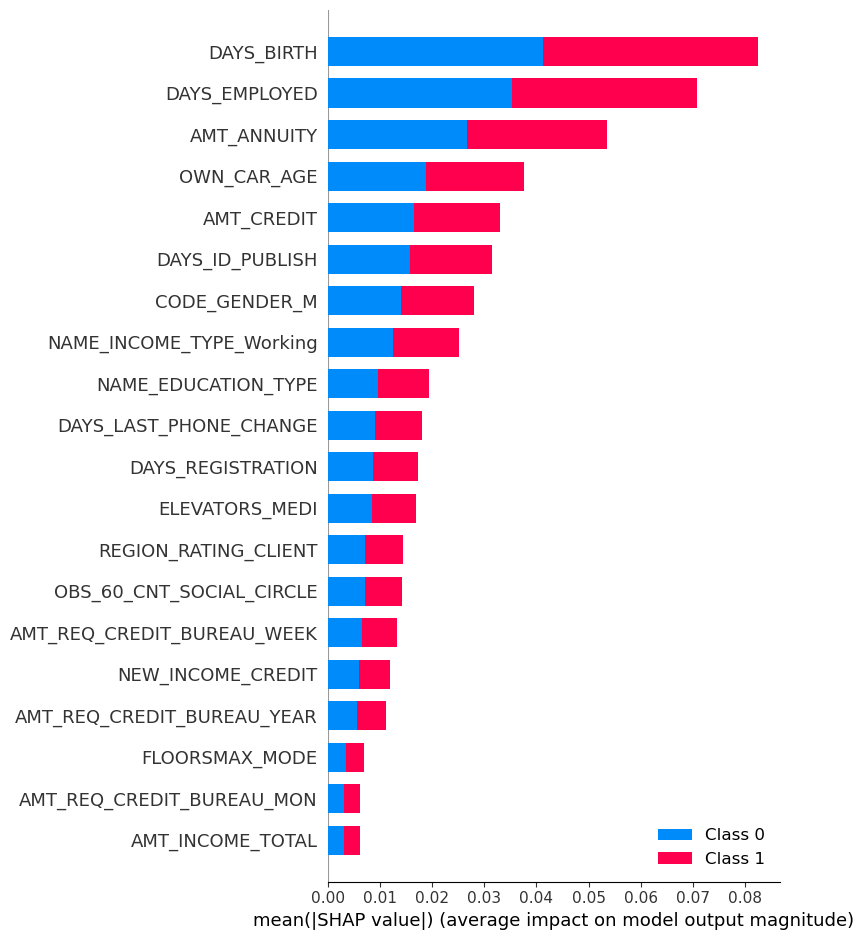

In [125]:
shap.summary_plot(sv, x_test, plot_type = 'bar')

**mean(|SHAP|) is about 0.3 on Classs 1, and 0.3 on Class 0. It means Days employed influence is the same Class 1 and Class 0. Also the Days employed is the most influential feature.**

### GridSearchCV with XGBoost

In [126]:
params = {
    'n_estimators': [100, 200, 500],
    'learning_rate': [0.01,0.05,0.1],
    'booster': ['gbtree', 'gblinear']}

In [127]:
grid_xgb = GridSearchCV(estimator=XGBClassifier(), param_grid=params, scoring=f2_score, cv=5, n_jobs=-1)

In [128]:
grid_xgb.fit(X_train_stan, y_train)

GridSearchCV(cv=5,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None,
                                     early_stopping_rounds=None,
                                     enable_categorical=False, eval_metric=None,
                                     feature_types=None, gamma=None,
                                     gpu_id=None, grow_policy=None,
                                     importance_type=None,
                                     interaction_constraints=None,
                                     learning_rate=None,...
                                     max_delta_step=None, max_depth=None,
                                     max_leaves=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     n_estimators=100, n_jobs=None,
                                     num_parallel_tree=None, predictor=None,
                                     random_state=None, ...),
             n_jobs=-1,
             param_grid={'booster': ['gbtree', 'gblinear'],
                         'learning_rate': [0.01, 0.05, 0.1],
                         'n_estimators': [100, 200, 500]},
             scoring=make_scorer(fbeta_score, beta=2, average=binary))

In [129]:
print(grid_xgb.best_params_)

# print how our model looks after hyper-parameter tuning
print(grid_xgb.best_estimator_)

print(grid_xgb.best_score_)

{'booster': 'gbtree', 'learning_rate': 0.05, 'n_estimators': 500}
XGBClassifier(base_score=None, booster='gbtree', callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.05, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=500, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=None, ...)
0.6341299139554195


In [130]:
y_pred = grid_xgb.predict(X_test_stan)
cm = confusion_matrix(y_test, y_pred)
cm

array([[35760, 20794],
       [ 1819,  3130]])

In [131]:
print('Recall for XGBoost:', recall_score(y_test, y_pred))

Recall for XGBoost: 0.632451000202061


### Plot the shap for XGBoost

In [132]:
xgb = grid_xgb.best_estimator_

In [133]:
explainer = shap.TreeExplainer(xgb)
shap_values = explainer.shap_values(x_test)

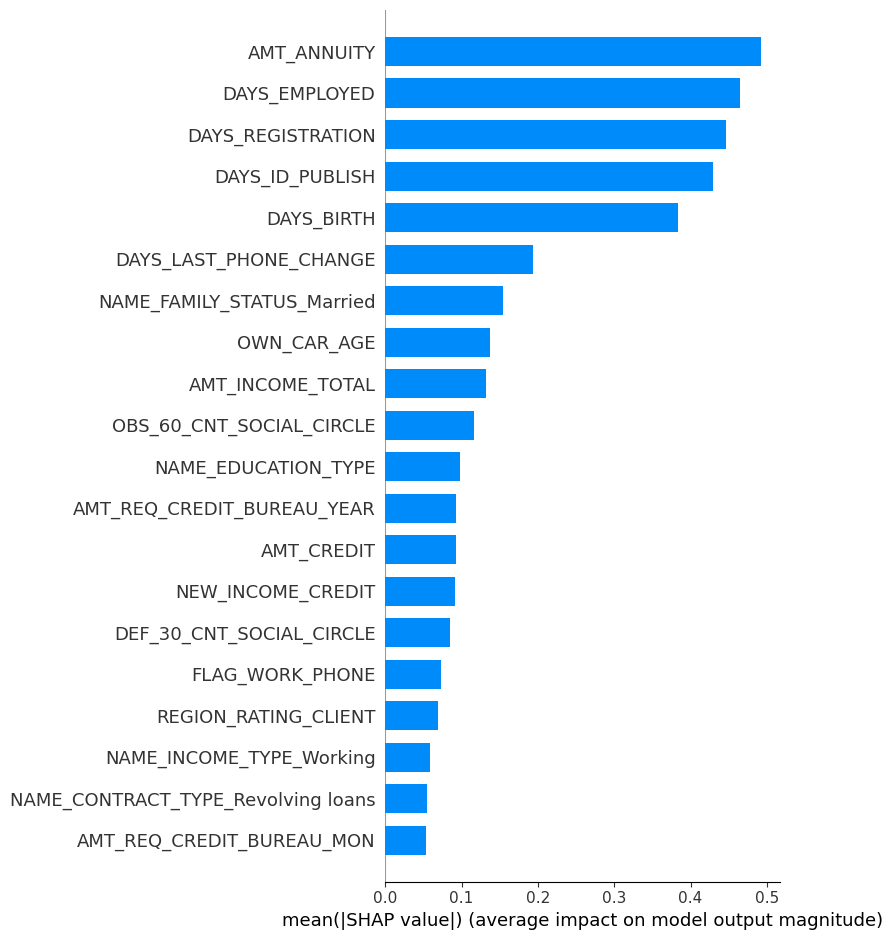

In [134]:
shap.summary_plot(shap_values, x_test, plot_type="bar")